<H3> Get samples from the model and check their distributions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *

import glob
import re
import os
import random

gpu = True

num_sequences = 500_000
batch_size = 500#setting for reconstruction
example_data = 'data\\peptide_train.txt'
save_dir_loc = 'model_analyses\\sample\\' #folder in which to save outpts
save_dir_name = 'train' #appended to identify data: train|test|other|etc...

ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoint
print('current working directory: ',os.getcwd())

for i in range(len(ckpt_list)):
    #search the current directory for the model name and load that model
    model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
    model_src = ckpt_list[i]
    print('working on: ',model_src,'\n')
    model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('\\')[-1]]))
    model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    
    #create save directory for the current model according to latent space size
    latent_size = re.findall('(latent[\d]{2,3})', model_src)
    save_dir= save_dir_loc+model.name+"_"+latent_size[0]+"_"+save_dir_name
    if not os.path.exists(save_dir):os.mkdir(save_dir) 
    save_dir= save_dir+"//" 
    save_df = pd.DataFrame() #this will hold the number variables and save to CSV
    
    #load the true labels
    data = pd.read_csv(example_data).to_numpy() 
    data_1D = data[:num_sequences,0] #gets rid of extra dimension
    
    #moving into latent memory
    if model.model_type =='aae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) #50_000
    elif model.model_type == 'wae':
        mus, _, _ = model.calc_mems(data[:65_000], log=False, save=False) 
    else:
        mems, mus, logvars = model.calc_mems(data[:65_000], log=False, save=False) #subset size 1200*35=42000 would be ok
    

current working directory:  c:\Users\sam\Documents\GitHub\latent-spaces-amps
working on:  checkpointz\to_slurm\aae_latent128\300_aae-128_peptide.ckpt 



KeyboardInterrupt: 

In [ ]:
#Section dealing with sequence generation metrics and bootstrapping from the latent space
#first randomly sample points within the latents space
rnd_seq_count =5_000
rnd_latent_list=[] #generate N latent space vectors

mem_var = 1.1
mem_mean = np.mean(mus, axis=0)

for seq in range(rnd_seq_count):
    rnd_latent_list.append(np.random.normal(mem_mean,mem_var).astype(np.float32))

model.params['BATCH_SIZE'] = 250
rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125

#decode these points into predicted amino acid tokens (integers)
for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
    rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(rnd_latent_list[batch:batch+model.params['BATCH_SIZE']]).cuda()).cpu()

#turn the tokens into characters
decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])
decoded_rnd_seqs[:]=[x for x in decoded_rnd_seqs if x] #removes the empty lists

decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 cu

In [ ]:
import peptides
dict_list=[]
#calculate physicochemical properties of generated sequences
for seq in decoded_rnd_seqs:
    pep = peptides.Peptide(seq)
    dict_list.append(
        {"aliphatic_index":pep.aliphatic_index(),
     "boman":pep.boman(),
     "charge_ph3":pep.charge(pH=3)/len(seq[0]),
     "charge_ph7":pep.charge(pH=7)/len(seq[0]),
     "charge_ph11":pep.charge(pH=11)/len(seq[0]),
    "hydrophobicity":pep.hydrophobicity(),
    "instability_index":pep.instability_index(),
    "isoelectric_point":pep.isoelectric_point(),
    "molecular_weight":pep.molecular_weight()} )
df = pd.DataFrame(dict_list)
df.to_csv('data/sampled_physicochem_props.csv',index=False)
sampled_props = pd.read_csv('data\\sampled_physicochem_props.csv')

In [ ]:
#re-calculate the test set properties as well
# dict_list=[]
# for seq in data_1D:
#     pep = peptides.Peptide(seq)
#     dict_list.append(
#         {"aliphatic_index":pep.aliphatic_index(),
#      "boman":pep.boman(),
#      "charge_ph3":pep.charge(pH=3)/len(seq[0]),
#      "charge_ph7":pep.charge(pH=7)/len(seq[0]),
#      "charge_ph11":pep.charge(pH=11)/len(seq[0]),
#     "hydrophobicity":pep.hydrophobicity(),
#     "instability_index":pep.instability_index(),
#     "isoelectric_point":pep.isoelectric_point(),
#     "molecular_weight":pep.molecular_weight()} )
# df = pd.DataFrame(dict_list)
# df.to_csv('data/new_train_physicochem_props.csv',index=False)
input_props = pd.read_csv('data\\new_train_physicochem_props.csv')


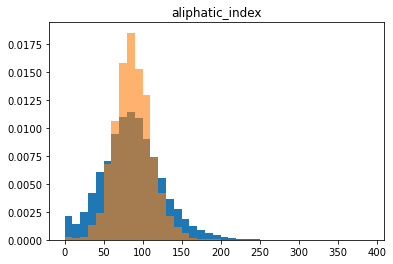

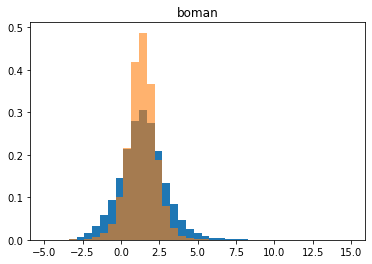

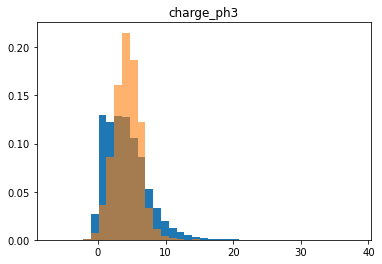

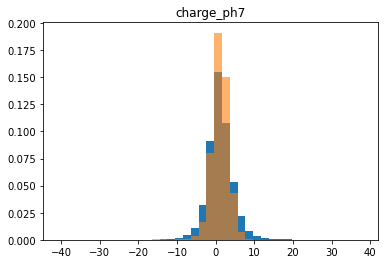

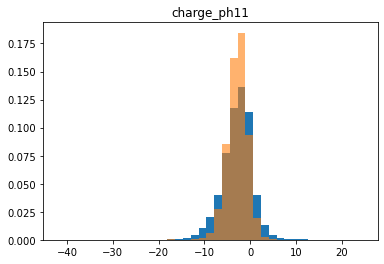

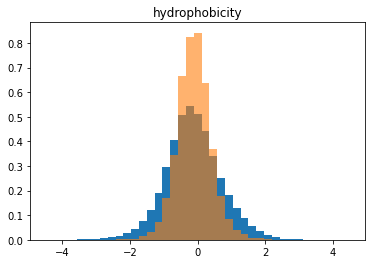

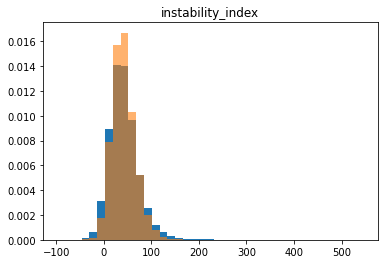

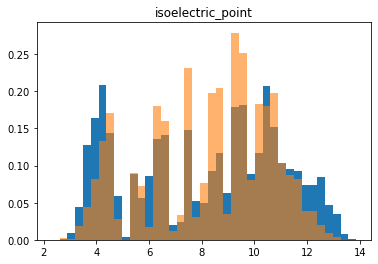

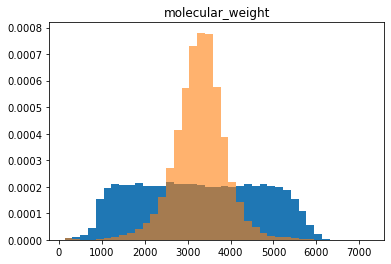

In [ ]:
for col in input_props.columns:
    if col=='hydrophobic_moment':
        continue
    plt.figure()
    bins = np.linspace(min(input_props[col]), max(input_props[col]), 40)
    plt.hist(input_props[col],bins=bins, density=True)
    plt.hist(sampled_props[col],bins=bins, density=True, alpha=0.6)
    plt.title('{}'.format(col))
    plt.savefig('distributions\\transformer_128_model_{}_distribution.png'.format(col),facecolor='white',transparent=None, dpi=600)
    

<h3> Checking AMP | NON-AMP Distributions in the training and testing data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import glob
import re
import os
import random

gpu = True

num_sequences = 500_000
batch_size = 500#setting for reconstruction
example_data = 'data\\peptide_test.txt'
save_dir_loc = 'distributions' #folder in which to save outpts
true_prop_src = 'data\\function_test.txt' #if property predictor load the true labels
save_dir_name = 'AMP_NON_AMP' #appended to identify data: train|test|other|etc...

# ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoint
# print('current working directory: ',os.getcwd())

save_dir= save_dir_loc+"_"+save_dir_name
if not os.path.exists(save_dir):os.mkdir(save_dir) 
save_dir= save_dir+"//" 

#load the true labels
data = pd.read_csv(example_data).to_numpy() 
data_1D = data[:num_sequences,0] #gets rid of extra dimension
true_props_data = pd.read_csv(true_prop_src).to_numpy()
true_props = true_props_data[0:num_sequences,0]
    


# for i in range(len(ckpt_list)):
#     #search the current directory for the model name and load that model
#     model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
#     model_src = ckpt_list[i]
#     print('working on: ',model_src,'\n')
#     model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('\\')[-1]]))
#     model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    
#     #create save directory for the current model according to latent space size
#     latent_size = re.findall('(latent[\d]{2,3})', model_src)
#     save_dir= save_dir_loc+model.name+"_"+latent_size[0]+"_"+save_dir_name
#     if not os.path.exists(save_dir):os.mkdir(save_dir) 
#     save_dir= save_dir+"//" 
#     save_df = pd.DataFrame() #this will hold the number variables and save to CSV
    
#     #load the true labels
#     data = pd.read_csv(example_data).to_numpy() 
#     data_1D = data[:num_sequences,0] #gets rid of extra dimension
#     true_props_data = pd.read_csv(true_prop_src).to_numpy()
#     true_props = true_props_data[0:num_sequences,0]
    

In [10]:
#load the physico-chemical properties from file: ORDER MUST BE THE SAME AS DATASET ORDER!
input_props = pd.read_csv('data\\new_test_physicochem_props.csv')

In [11]:
amp_property_list=[]
non_amp_property_list=[]
for idx, amp_check in enumerate(true_props):
    if amp_check==1:
        amp_property_list.append(input_props.iloc[idx])
    else:
        non_amp_property_list.append(input_props.iloc[idx])
assert len(amp_property_list+non_amp_property_list) == input_props.shape[0] #just check that the split happened correctly
amp_property_df = pd.DataFrame(amp_property_list)
non_amp_propertly_df = pd.DataFrame(non_amp_property_list)

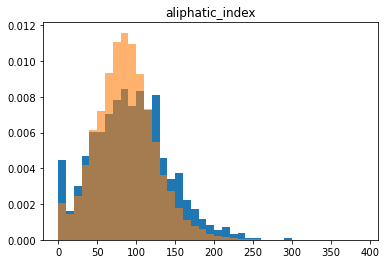

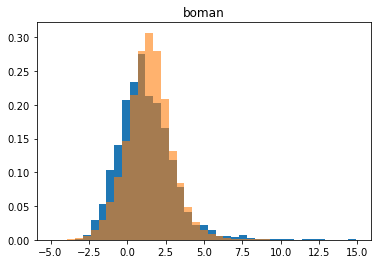

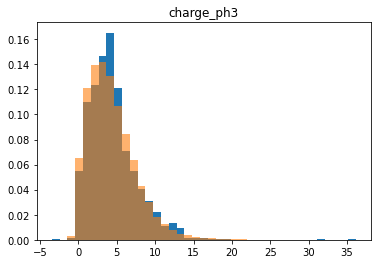

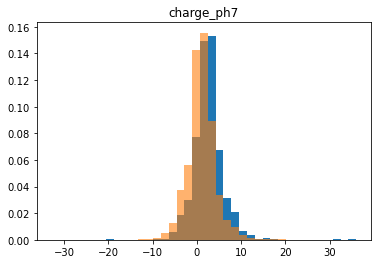

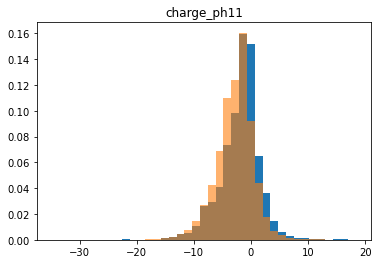

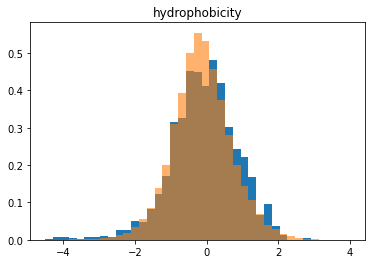

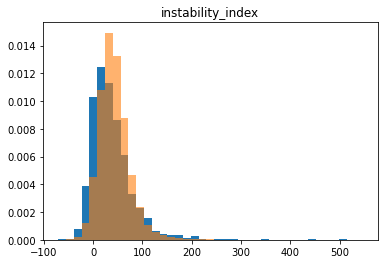

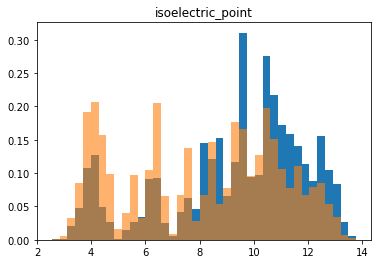

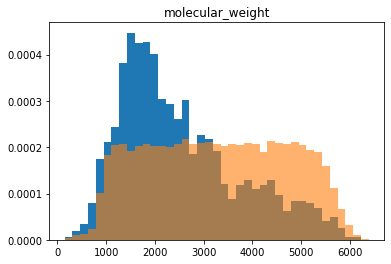

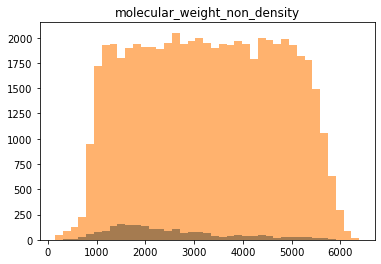

In [15]:
for col in amp_property_df.columns:
    if col=='hydrophobic_moment':
        continue
    plt.figure()
    bins = np.linspace(min(input_props[col]), max(input_props[col]), 40)
    plt.hist(amp_property_df[col],bins=bins, density=True)
    plt.hist(non_amp_propertly_df[col],bins=bins, density=True, alpha=0.6)
    plt.title('{}'.format(col))
    plt.savefig(save_dir+"{}.png".format(col),facecolor='white',transparent=None, dpi=600)
    if col=='molecular_weight':
        plt.figure()
        plt.hist(amp_property_df[col],bins=bins, density=False)
        plt.hist(non_amp_propertly_df[col],bins=bins, density=False, alpha=0.6)
        plt.title('{}_non_density'.format(col))
        plt.savefig(save_dir+"{}_non_density.png".format(col),facecolor='white',transparent=None, dpi=600)